# Week 12: U-Net
## Convolutional Networks for Image Segmentation

Olaf Ronneberger, Philipp Fischer, and Thomas Brox
2015

U-Net is a segmentation network whose architecture resembles the letter "u". The network "contracts to capture context and a symmetric expanding path that enables precise localization" (Ronnenberger et al. 2015).

![unet.PNG](https://github.com/UMT-CSCI-591-Deep-Learning-2022/Week_13_unet/blob/main/unet.PNG?raw=1)

The example provided here will use a dataset of images we chose to use is labeled to classify cars. There are two labels in these images ('car' and 'not car'). 


## Weighted Mask

The use of the standard categorical cross-entropy loss function in U-net can be problematic for biomedical image segmentation:  
* When using this loss function, the model is rewarded for classifying narrow cell boundaries as being in-cell pixels because they are close to many other in-cell pixels  
* While this might not reduce the overall accuracy much, it reduces the usefulness of the segmentation result  
* To mitigate this problem, the implementation from the paper includes a weight map that is used to add a weight value to the loss function.  

This weight map is calculated as follows:

$$\Large
w(x) = w_c(x) + w_0\ \cdot\ exp\ (-\ \frac{(d_1(x) + d_2(x))^2}{2 \sigma^2})
$$

$$\small  
x\ is\ the\ current\ pixel \\  
w_c\ is\ the\ class\ weighting\ that\ upweights\ classes\ differently \\  
d_1\ is\ the\ distance\ to\ the\ nearest\ cell\ boundary \\  
d_2\ is\ the\ distance\ to\ the\ second\ nearest\ cell\ boundary \\  
w_0\ and\ \sigma\ are\ constants\ that\ scale\ the\ weighting $$  
  
### Example:  
Let's implement this in code. First we need to develop a function that can generate random cells to simulate a microscopy image:


In [1]:
# from skimage.io import imshow
from skimage.measure import label
from scipy.ndimage.morphology import distance_transform_edt
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import os

def generate_random_circles(n = 50, d = 100, cell_size = 20):

  """
  Generate a numpy array that is a simulated mask for an image of 
  cells where the in-cell pixels are 1 and background pixels are 0. 
  Used as prelimiary generator for unet_weight_map function.

  Parameters
  ----------
  n:  int
      Number of cells to be created
  d:  int
      Dictionary of weight classes.
  Returns
  -------
  Numpy array
      Simulated mask for a cell-image. A 2D array of shape (d,d).
  """
  # Generate coordinates for random circles
  circles = np.random.randint(0, d, (n, 3))
  # Ensure radius (3rd col) is between d/3 and d
  circles[:,2] = np.interp(circles[:,2], (circles[:,2].max(), circles[:,2].max()), (d/3,d))

  # Generate background for simluated cell image 
  x = np.zeros((d, d), dtype=int)
  
  # Iterate over circles and insert into simulated image
  for x0, y0, r in circles:
    copy_x = deepcopy(x)
    # Generate new 2D array with circle of pixels with value 1 for current circle
    new_x = np.fromfunction(lambda x, y: ((x - x0)**2 + (y - y0)**2) <= (r/d*cell_size)**2, x.shape)
    
    # Add new circle to cell map
    for i in range(1,len(new_x)-1):
      for j in range(1,len(new_x[0])-1):
        # Only add to cell map if neighbours are 0
        if new_x[i][j] == True and x[i-1][j]==0 and x[i-1][j-1]==0 and x[i][j-1]==0 and x[i][j+1]==0 and x[i+1][j+1]==0 and x[i+1][j]==0 and x[i+1][j-1]==0 and x[i-1][j+1]==0:
          copy_x[i][j] += new_x[i][j]
    x += copy_x
  
  # Clip values above 1 to a max of 1
  x = np.clip(x, 0, 1)

  # Return simulated cell map
  return x

Second we need to implement the weighting function that weights each pixel in the image based on it's distance to the nearest cell boundaries:

In [2]:

def unet_weight_map(y, wc=None, w0 = 10, sigma = 5):

  """
  Generate weight maps as specified in the U-Net paper
  for boolean mask.
  
  "U-Net: Convolutional Networks for Biomedical Image Segmentation"
  https://arxiv.org/pdf/1505.04597.pdf
  
  Parameters
  ----------
  mask: Numpy array
      2D array of shape (image_height, image_width) representing binary mask
      of objects.
  wc: dict
      Dictionary of weight classes.
  w0: int
      Border weight parameter.
  sigma: int
      Border width parameter.
  Returns
  -------
  Numpy array
      Training weights. A 2D array of shape (image_height, image_width).
  """
  
  # Grab labels from input
  labels = label(y)
  no_labels = labels == 0
  label_ids = sorted(np.unique(labels))[1:]

  # Check for circles in y
  if len(label_ids) > 1:
    # Calculate distances
    distances = np.zeros((y.shape[0], y.shape[1], len(label_ids)))
    for i, label_id in enumerate(label_ids):
      distances[:,:,i] = distance_transform_edt(labels != label_id)

    # Sort for nearest cell boundary distances
    distances = np.sort(distances, axis=2)
    d1 = distances[:,:,0]
    d2 = distances[:,:,1]
    
    # Calculate second term in weighting equation
    w = w0 * np.exp(-1/2*((d1 + d2) / sigma)**2) * no_labels

    # Sum with class weights to produce weighted mask
    if wc:
      class_weights = np.zeros_like(y)
      for k, v in wc.items():
        class_weights[y == k] = v
      w = w + class_weights
  
  # If no circles we passed in to the function, return zeros
  else:
    w = np.zeros_like(y)
  
  # Return weighted mask
  return w


Let's generate a simulated cell image mask and then weight the pixels of that mask. You need to choose weighting values for the two classes, cell and non-cell:

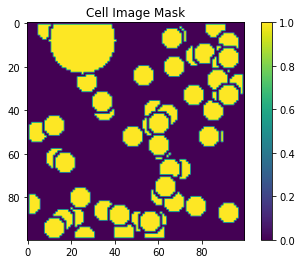

Class Weighting: {0: 5, 1: 3}


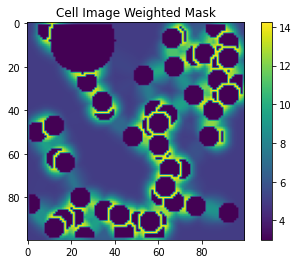

In [3]:
# Generate simulated cell mask 
num_cells        = 60
image_dimensions = 100
cell_size        = 15
y = generate_random_circles(num_cells, image_dimensions, cell_size)

# Display cell mask
plt.imshow(y)
plt.title('Cell Image Mask')
plt.colorbar()
plt.show()

# Weighting for pixels assigned to the two classes
class_weighting = {
  # TODO: Choose weighting values for the classes in the cell mask - they are currently set to 0.
  0: 5, # background
  1: 3  # cells
}

print('Class Weighting:', class_weighting)

# Generate weighted map
w = unet_weight_map(y, class_weighting)

# Display weighted mask
plt.imshow(w)
plt.title('Cell Image Weighted Mask')
plt.colorbar()
plt.show()

**TO DO: Try adjusting the weighting of the class in the class_weighting dictionary (or other parameters) and see what impact that has on the final weighted mask.**

Regardless of whether background or cells receive higher weight, the weights are significantly increased around the cell borders, exactly as expected.

# Implementing U-Net

In [4]:
import torch
import torch.nn as nn
import torchvision.transforms as TF

We use the double convolution quite a lot in this architecture so let's implement it as a reusable code block.

In [5]:

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),  # 3x3 convolution
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


Now let's devise the network using Pytorch functionality.

In [6]:

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.functional.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

For a sanity check, let's just make sure that we are getting a prediction that is the shape we would expect.

**QUESTION: Given the shape of the torch.randn() and the fact that we're using padding, what do you expect the output shape to be?**

Looks like a 50x50 RGB image to me.


In [8]:
x = torch.randn((3, 1, 50, 50))
model = UNET(in_channels=1, out_channels=1)
preds = model(x)
assert preds.shape == x.shape


### Dataset Loader
Now we'll prepare our data for training and testing using Pytorch's DataLoader which will pass in samples in “minibatches”.

In [9]:
from PIL import Image
from torch.utils.data import Dataset

class CarDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", "_mask.gif"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

### Useful Utility Functions
Some of the operations we perform can be functionalized to save on repetition. The two examples below are getting the data loaders and validating the model.

In [10]:
from torch.utils.data import DataLoader

def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
):
    train_ds = CarDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
    )

    val_ds = CarDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader

def validation_accuracy(loader, model):
    num_correct = 0
    num_pixels = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x
            y = y.unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
    print(f"Got {num_correct}/{num_pixels} pixels with acc {num_correct/num_pixels*100:.2f}")
    model.train()

### Training Function

In [11]:
def train_fn(loader, model, optimizer, loss_fn):

    for batch_idx, (data, targets) in enumerate(loader):

        # forward
        predictions = model(data)
        loss = loss_fn(predictions, targets.float().unsqueeze(1))

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Iter: {batch_idx+1}/{len(loader.dataset)}, Loss: {loss.item():.04f}")


### Hyperparameters
Choose hyperparameters for the model. Experiment with the learning rate and batch size.

In [13]:
# Hyperparameters

# TODO: experiment with different values
LEARNING_RATE = 1e-3
BATCH_SIZE = 8 

IMAGE_HEIGHT = 160  # 1280 originally
IMAGE_WIDTH = 240  # 1918 originally
LOAD_MODEL = False

cwd = os.getcwd()

TRAIN_IMG_DIR = os.path.join(cwd, "data", "train_images")
TRAIN_MASK_DIR = os.path.join(cwd, "data", "train_masks")
VAL_IMG_DIR = os.path.join(cwd, "data", "val_images")
VAL_MASK_DIR = os.path.join(cwd, "data", "val_masks")

### Data Transformation
The images in this dataset are quite large, so we will need to reduce the size in order to make the training time a little more reasonable. While this might sacrifice some accuracy due to compression, we can run more data through the model during training this way.

In [ ]:
# ! pip install albumentations==0.4.6

In [15]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

train_transform = A.Compose(
  [
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(
      mean=[0.0, 0.0, 0.0],
      std=[1.0, 1.0, 1.0],
      max_pixel_value=255.0,
    ),
    ToTensorV2(),
  ],
)

val_transforms = A.Compose(
  [
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(
      mean=[0.0, 0.0, 0.0],
      std=[1.0, 1.0, 1.0],
      max_pixel_value=255.0,
    ),
    ToTensorV2(),
  ],
)


### Training the Model

**Question: Why do we use the BCEWithLogitsLoss function for training the model?**  
The documentation is [here](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html).

**Answer:** BCEWithLogitsLoss is good for handling classification probabilities before the softmax transformation, which is precisely the type of data output by our UNet model. 

**Question: Given the authors of the original U-Net paper chose SGD, is Adam the best optimizer for this implementation?**  
Consider trying [a couple of different ones](https://pytorch.org/docs/stable/optim.html#algorithms) and see what happens.



In [16]:
model = UNET(in_channels=3, out_channels=1)

loss_fn = nn.BCEWithLogitsLoss()

import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loader, val_loader = get_loaders(
  TRAIN_IMG_DIR,
  TRAIN_MASK_DIR,
  VAL_IMG_DIR,
  VAL_MASK_DIR,
  BATCH_SIZE,
  train_transform,
  val_transforms,
)

train_fn(train_loader, model, optimizer, loss_fn)


Iter: 1/224, Loss: 0.6742
Iter: 2/224, Loss: 0.5410
Iter: 3/224, Loss: 0.4741
Iter: 4/224, Loss: 0.3823
Iter: 5/224, Loss: 0.4674
Iter: 6/224, Loss: 0.3294
Iter: 7/224, Loss: 0.4028
Iter: 8/224, Loss: 0.3264
Iter: 9/224, Loss: 0.3018
Iter: 10/224, Loss: 0.2766
Iter: 11/224, Loss: 0.2931
Iter: 12/224, Loss: 0.2890
Iter: 13/224, Loss: 0.2590
Iter: 14/224, Loss: 0.2423
Iter: 15/224, Loss: 0.2374
Iter: 17/224, Loss: 0.2176
Iter: 18/224, Loss: 0.2129
Iter: 19/224, Loss: 0.2087
Iter: 20/224, Loss: 0.2099
Iter: 21/224, Loss: 0.1899
Iter: 22/224, Loss: 0.1847
Iter: 23/224, Loss: 0.1958
Iter: 24/224, Loss: 0.2259
Iter: 25/224, Loss: 0.1871
Iter: 26/224, Loss: 0.1771
Iter: 27/224, Loss: 0.1767
Iter: 28/224, Loss: 0.1859


### Validating the Model

In [17]:
validation_accuracy(val_loader, model)

Got 1901903/2457600 pixels with acc 77.39


Let's visualise a couple randomly selected validation predictions and see how well the model did.

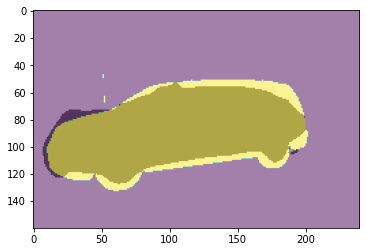

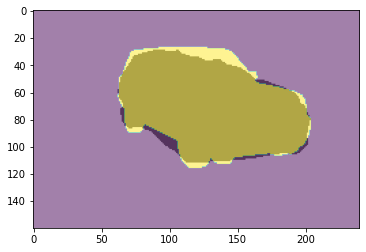

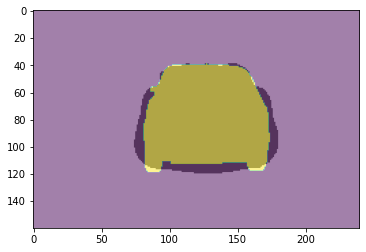

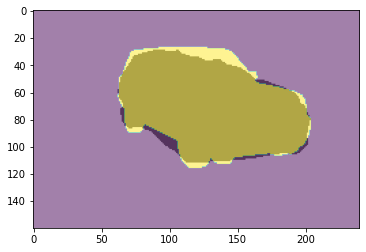

In [19]:
# TODO: how many predictions do you want to visualize?
num_predictions = 4

for i in range(num_predictions):
  # select a random image
  idx = np.random.randint(0, len(val_loader.dataset))
  # Get a prediction with that image
  pred = torch.sigmoid(model(val_loader.dataset[idx][0].unsqueeze(0)))
  pred = (pred > 0.5).float()
  # display the prediction overlaid with the target mask
  plt.imshow(pred.squeeze(), cmap="Greys", alpha=0.6)
  plt.imshow(TF.ToPILImage()(val_loader.dataset[idx][1]).convert('L'), alpha=0.5)
  plt.show()
  

**Question: What you do notice about the predicted mask that is less than optimal?**  

The predicted mask tends to "color outside the lines." It does a pretty good job in general though!   

### Data Augmentation
Let's train the model on some new data (in a sense). We can augment the data that we feed to the model by performing horizontal flips on the images of the cars, or even changing the distribution of the normalized values. 

In [20]:
train_transform = A.Compose(
  [
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.Normalize(
      mean=[0.0, 0.0, 0.0],
      std=[2.0, 2.0, 2.0],
      max_pixel_value=255.0,
    ),
    ToTensorV2(),
  ],
)

val_transforms = A.Compose(
  [
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.Normalize(
      mean=[0.0, 0.0, 0.0],
      std=[2.0, 2.0, 2.0],
      max_pixel_value=255.0,
    ),
    ToTensorV2(),
  ],
)

train_loader, val_loader = get_loaders(
  TRAIN_IMG_DIR,
  TRAIN_MASK_DIR,
  VAL_IMG_DIR,
  VAL_MASK_DIR,
  BATCH_SIZE,
  train_transform,
  val_transforms,
)


Now continue training the model:

In [21]:
train_fn(train_loader, model, optimizer, loss_fn)

Iter: 1/224, Loss: 0.1746
Iter: 2/224, Loss: 0.1727
Iter: 3/224, Loss: 0.1604
Iter: 4/224, Loss: 0.1596
Iter: 5/224, Loss: 0.1680
Iter: 6/224, Loss: 0.1553
Iter: 7/224, Loss: 0.1498
Iter: 8/224, Loss: 0.1464
Iter: 9/224, Loss: 0.1446
Iter: 10/224, Loss: 0.1494
Iter: 11/224, Loss: 0.1424
Iter: 12/224, Loss: 0.1367
Iter: 13/224, Loss: 0.1261
Iter: 14/224, Loss: 0.1188
Iter: 16/224, Loss: 0.1211
Iter: 17/224, Loss: 0.1376
Iter: 18/224, Loss: 0.1268
Iter: 19/224, Loss: 0.1186
Iter: 20/224, Loss: 0.1139
Iter: 21/224, Loss: 0.1201
Iter: 22/224, Loss: 0.1132
Iter: 24/224, Loss: 0.1197
Iter: 26/224, Loss: 0.1201
Iter: 27/224, Loss: 0.1034
Iter: 28/224, Loss: 0.1093


Take a look at some of the model predictions.  
  
**Question: How has the model performance changed and why?**  

**Answer:** Some really interesting results here! Surprisingly, the performance of the masking seems to demonstrate severe overfitting: In several of the results, the shape of the car is identical to the target mask, but precisely reflected about the center of the image. It would seem that there are characteristics from the trained image that suggest the orientation of the car, but UNet "committed" to going the wrong way (almost like it had a 50/50 chance of guessing the correct orientation.)

An alternative explanation is that this is a bug, and the images are being retrieved such that there is a chance of reflecting the target mask...in which case UNet trained on the augmented data has developed excellent robustness to orientation.  


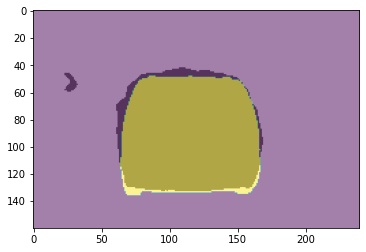

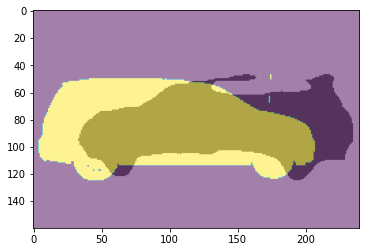

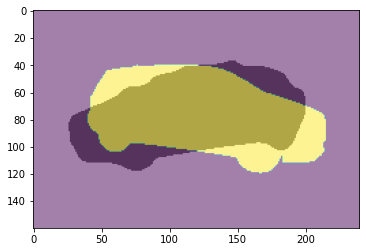

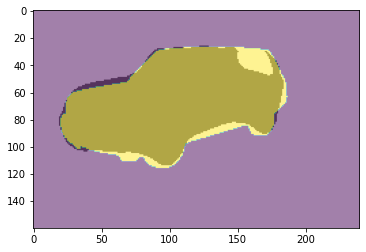

In [24]:
# TODO: how many predictions do you want to visualize?
num_predictions = 4

for i in range(num_predictions):
  # select a random image
  idx = np.random.randint(0, len(val_loader.dataset))
  # Get a prediction with that image
  pred = torch.sigmoid(model(val_loader.dataset[idx][0].unsqueeze(0)))
  pred = (pred > 0.5).float()
  # display the prediction overlaid with the target mask
  plt.imshow(pred.squeeze(), cmap="Greys", alpha=0.6)
  plt.imshow(TF.ToPILImage()(val_loader.dataset[idx][1]).convert('L'), alpha=0.5)
  plt.show()


**As an optional final task, try training a new model on variations of augmented data and see how the performance changes with different augmentations.** 